# Regresja logistyczna

Zbudujemy klasyfikator bazujący na regresji logistycznej. Jego zadaniem będzie określanie prawdopodobieństwa przyjęcia kandydata na studia na podstawie wyników z dwóch egzaminów maturalnych (każdy przeskalowany na zakres 0-100%): z matematyki i z biologii. 

### Przygotowanie środowiska programistycznego

In [178]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.optimize as so

Zestaw uczący pobieramy z repozytorium github i wczytujemy używając klasy Pandas DataFrame. Najpierw pobieramy repozytorium z github. Repozytorium zawiera kod do naszych ćwiczeń, oraz przykładowe dane w katalogu "dane".

```
!git clone https://github.com/akalinow/Uczenie_maszynowe -b 2022_2023
!ln -s /content/uczenie-maszynowe-2021-22/dane/ dane
```

In [179]:
df = pd.read_csv("dane/reg_log_data.txt", encoding='latin-1', sep=",", names=["matematyka", "biologia", "wynik"])

## Analiza wizualna danych. 

Pierwszy krok przy analizie danych z użyciem dowolnego algorytmu to ich inspekcja. Korzystając z metod klasy DataFrame.

**Proszę:**
* wypisać na ekran framgent danych
* narysować rozkłady wszystkich zmiennych wejściowych, w naszym przypadku wyniku egzaminów z matematyki i biologii dla całego zbioru
* narysować rozkłady wszystkich zmiennych wejściowych, w naszym przypadku wyniku egzaminów z matematyki i biologii dla wierszy gdzie wynik=0
* narysować rozkłady wszystkich zmiennych wejściowych, w naszym przypadku wyniku egzaminów z matematyki i biologii dla wierszy gdzie wynik=1

**Wskazówka**: proszę użyć filtrowania danych, tak jak to było robione na pierwszych zajęciach.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   matematyka  100 non-null    float64
 1   biologia    100 non-null    float64
 2   wynik       100 non-null    int64  
dtypes: float64(2), int64(1)
memory usage: 2.5 KB


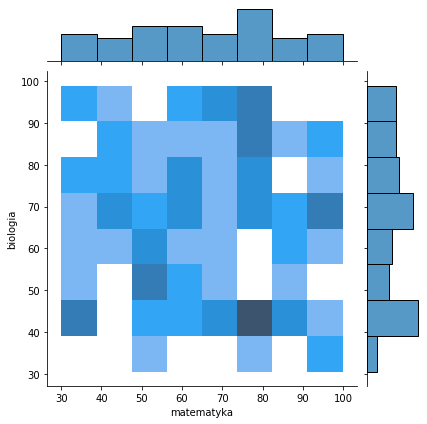

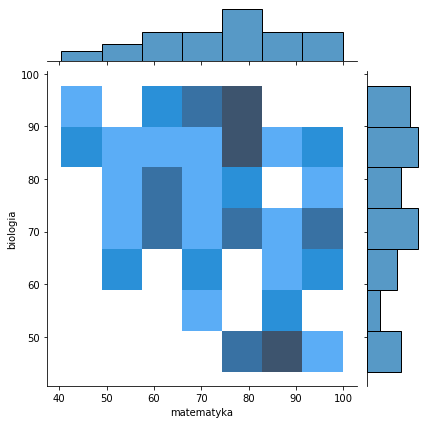

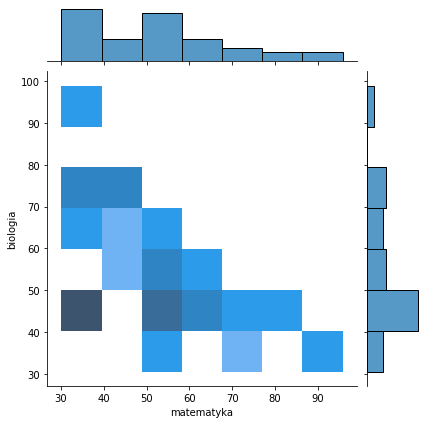

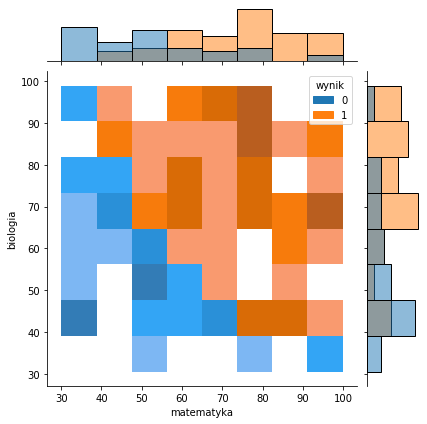

In [180]:
# określenie rozmiaru rysunku
figsize=(15,5)
# wypisanie informacji o dataframe
df.info()
# histogramy dla wszystkich kolumn w danych

# df.hist(figsize=figsize)
# histogramy tylko dla osób które zdały

df_passed = df[df['wynik']==1]
# df_passed.hist(figsize=figsize)

# # histogramy dla osób które nie zdały
df_failed = df[df['wynik']==0]
# df_failed.hist(figsize=figsize)

# #wykres dla wszyskich danych. Kategorie zdali/nie zdali są zaznaczone odpowiednim kolorem
# df.hist(figsize=figsize, by="wynik");

# SEABORN
# pelen histogram
sns.jointplot(data=df, x="matematyka", y="biologia", kind='hist')  # hue odcien na podstawie ktorej kolumny

# zdane
sns.jointplot(data=df_passed, x="matematyka", y="biologia", kind='hist')

# niezdane
sns.jointplot(data=df_failed, x="matematyka", y="biologia", kind='hist')

# dwa hist na jedynyn
sns.jointplot(data=df, x="matematyka", y="biologia", kind='hist', hue='wynik')  # hue odcien na podstawie ktorej kolumny

## Hipoteza
Dla przypomnienia _hipoteza_ w regresji logistycznej ma postać: 

$\qquad$ $h_\theta(x) = \frac{1}{1+\exp(-\theta x^T )}$.

W implementacji dobrze jest myśleć o tej funkcji tak:

$\qquad$ $h_\theta(x) = \frac{1}{1+f}$.

gdzie: $f = \exp(-\theta x^T)$

**Proszę** napisać funkcję ```logistic_func(x, theta)``` która:

* implementuje funkcję logistyczną
* jako argumenty przyjmuje parametry regresji logistycznej  $(\theta_{0}, \theta_{1}, ..., \theta_{i})$ oraz tablicę danych wejściowych $x$. 
* w kodzie fukcji proszę rozszerzyć tablicę $x$ o dodatkową kolumnę jedynek, by parametr $\theta_{0}$ był traktowany na tej same zasadzie co pozostałe parametry
* ze względu na stabilność numeryczną obliczeń ma ograniczony zakres zmienności. Proszę ograniczyć wartości wykładnika w mianowniku do zakresu  $\pm18$

**Ostrzeżenie:** x to tablica która może zawierać wiele kolumn i wiele wierszy.

**Wskazówka**: ograniczając zakres zwracanych wartości proszę skorzystać z funkcji np.where() zaaplikowanej do wektora wartości wykładnika.

Proszę sprawdzić działanie funkcji na następujących danych testowych:
```Python
theta = np.array([1,1,2])
x = np.array([[5,5],
              [5,6],
              [-5,-5],
              [-5,-8]])
```
Oczekiwany wynik:
```
[9.99999887e-01 9.99999985e-01 8.31528028e-07 1.52299795e-08]
```

In [181]:
def logistic_func(theta, x):
    # dodaj kolumne jedynek
    x_expanded = np.column_stack((np.ones(x.shape[0]), x))
    # policz argument funkcji
    arg = np.sum(theta*x_expanded, axis=1)
    # uzyj np.where żeby ograniczyc wartosci parmetru do [-18,18]
    arg = np.where(np.abs(arg) > 18, 18*np.sign(arg), arg)
    return 1.0/(1+np.exp(-arg))

theta = np.array([1,1,2])
x = np.array([[5,5],
              [5,6],
              [-5,-5],
              [-5,-8]])
res = logistic_func(theta, x)

# sprawdzenie poprawności rozmiaru listy
assert res.shape == (4,)
print(res)

[9.99999887e-01 9.99999985e-01 8.31528028e-07 1.52299795e-08]


## Funkcja log-wiarygodności (LLH): 
Parametry regresji znajdujemy przez maksymalizację [funkcji log-wiarygodności](https://brain.fuw.edu.pl/edu/index.php/Uczenie_maszynowe_i_sztuczne_sieci_neuronowe/Wykład_6#Funkcja_wiarygodno.C5.9Bci):

$\qquad$ $l(\theta) = \log L(\theta) = \sum_{j=1}^m y^{(j)} \log h(x^{(j)}) + (1 - y^{(j)}) \log (1 - h(x^{(j)}))$,
gdzie:  

m - liczebność próbki

x - dane wejściowe, u nas wyniki z egaminów z matematyki i biologii

y - dane wyjściowe, u nas wynik rekrutacji na studia

h - postać zależności wyniku od danych wejściowych. U nas to jest funkcja logistyczna, czyli oczekujemy, że wzór y = h(x) dobrze opisuje zależnośc między danymi wejściowymi, a wyjściowymi.


<hr>

**Proszę** napisać funkcję ```log_likelihood(theta, x,y, model)``` która:

* implementuje funkcję log-wiarygodności
* jako argumenty przyjmuje parametry regresji logistycznej  $(\theta_{0}, \theta_{1}, ..., \theta_{i})$ oraz tablicę danych wejściowych $x, y$. 
* model dla którego szukamy parametrów $\theta_{i}$ w naszym przypadku to będzie funkcja logistyczna: ```logistic_func```

**Uwaga**: argument $theta$ musi być pierwszy 

In [182]:
def log_likelihood(theta, x, y, model):
    # x_expanded = np.column_stack((np.ones(x.shape[0]), x))
    tosum = y*np.log(model(theta, x))+(1-y)*np.log(1-model(theta, x))
    result = np.sum(tosum, axis=0)

    return result

Maksymalizacja to zadanie optymalizacyjne - szukamy optymalnych parametrów, a kryterium optymalności to maksymalna wartość funckji log-wiarygodności.
W tym ćwiczeniu zrobimy to za pomocą funkcji optymalizacyjnych z modułu [<tt>scipy.optimize</tt>]( http://docs.scipy.org/doc/scipy/reference/optimize.html#module-scipy.optimize). 


Wynikają z tego dwie konsekwencje:
* funkcje te są przystosowane do szukania minimów funkcji celu. Musimy więc podawać im jako argumenty funkcję minus log-wiarygodności
* niektóre algorytmy mogą działać szybciej jeśli zaimplementujemy jawnie postać pochodnej:

$\qquad$ $
\begin{array}{lcl}
\frac{\partial}{\partial \theta_i} l(\theta)  =\sum_{j=1}^m (y^{(j)}-h_\theta(x^{(j)}))x_i^{(j)}
\end{array}
$

**Proszę** napisać funkcję ```negative_log_likelihood(theta, x,y, model)``` która:

* zwraca funkcję log-wiarygodności pomnożoną przez $-1$

In [183]:
def negative_log_likelihood(theta, x, y, model):
    return -log_likelihood(theta, x, y, model)

**Proszę** napisać funkcję ```log_likelihood_derivative(theta, x,y, model)``` oraz ```negative_log_likelihood_derivative(theta, x,y, model)``` które:

* zwraca funkcję pochodną log-wiarygodności
* zwraca funkcję pochodną log-wiarygodności pomnożoną przez $-1$

**Uwaga**: mnożąc przez $x_{i}$ trzeba uwzględnić kolumnę jedynek

In [184]:
def log_likelihood_derivative(theta, x, y, model):
    # odpowiedź modelu na dane
    # różnica odpowiedzi modelu i wartości prawdziwej
    x_expanded = np.column_stack((np.ones(x.shape[0]), x))
    # print(x_expanded)
    # obliczenie pochodnej wysumowanej po wszyskich przykładach

    delta = y - model(theta, x)
    delta = np.array(delta)
    delta = np.column_stack((delta, delta, delta))
    tosum = delta*x_expanded    # tu jest problem
    # print(tosum)
    result = np.sum(tosum, axis=0)
    #sprawdzenie poprawności rozmiaru wyniku
    assert result.shape == theta.shape
    return result

def negative_log_likelihood_derivative(theta, x, y, model):
    return -log_likelihood_derivative(theta, x, y, model)

## Procedura minimalizacji funkcji log-wiarygodności ze wsględu na parametry $\theta$ dla konkretnych danych.

W naszym przypadku mamy trzy parametry $\theta$ - mnożące odpowiednio 1, wynik z matematyki, wynik z biologii.

**Proszę:**
* zainicjalizować parametry $\theta_{0}, \theta_{1}, \theta_{2}$ na wartości 0.
* obliczyć wartość i pochodną funkcji wiarygodności na danych początkowych 

Poprawny wynik to:
```
Wartość funkcji log-wiarygodności dla zbioru testowego = -69.31471805599453
Wartość pochodnej funkcji log-wiarygodności dla zbioru testowego = [  10.         1200.92165893 1126.28422055]
```

In [185]:
theta = np.array([0, 0, 0])

x = df[['matematyka', 'biologia']]
y = df['wynik']

# wartość funkcji log-wiarygodności

llh = log_likelihood(theta, x, y, logistic_func)

# wartość pochodnej

llh_derivative = log_likelihood_derivative(theta, x, y, logistic_func)

print("Wartość funkcji log-wiarygodności dla zbioru testowego = {}".format(llh))
print("Wartość pochodnej funkcji log-wiarygodności dla zbioru testowego = {}".format(llh_derivative))

Wartość funkcji log-wiarygodności dla zbioru testowego = -69.31471805599453
Wartość pochodnej funkcji log-wiarygodności dla zbioru testowego = [  10.         1200.92165893 1126.28422055]


## Optymalizacja  

Funkcje optymalizujące zaczerpniemy z modułu scipy.optimize: ```scipy.optimize.fmin_bfgs```. Ponieważ funkcje te są zaimplementowane do mnimalizowania to zamiast maksymalizować funkcję low-wiarygodności będziemy minimalizować tą funkcje przemnożoną przez -1 czyli ```f=negative_log_likelihood``` oraz ```fprime=negative_log_likelihood_derivative```

**Proszę:**

* wywołać funckję ```scipy.optimize.fmin_bfgs``` z odpowiednimi argumentami.
* porównać liczbę wywołań i czas wykonywania komórki z i bez podania explicite postaci pochodnej
(https://ipython.readthedocs.io/en/stable/interactive/magics.html?highlight=%25time#cell-magics)

Oczekiwany wynik:
```
Optymalne wartości parametrów theta: [-25.16123454   0.20623093   0.20147076]
Wartość funkcji log-wiarygodności dla optymalnych parametrów: -20.349770159101467
```

# Wysłać skrin tego, że zadziałała normalizacja do pracy domowej 07.11.2022

In [186]:
%%time 
# komenda ``time``` włącza licznik czasu wykonywania komórki

model = logistic_func

# poszukiwanie optymalnych wartości parametrów theta
theta_opt = so.fmin_bfgs(f=negative_log_likelihood, fprime=negative_log_likelihood_derivative, x0=theta, args=(x, y, model), disp=True)
# wartość LLH z optymalnymi parametrami

llh = log_likelihood(theta_opt, x, y, model)

print('Optymalne wartości parametrów theta: {}'.format(theta_opt))
print("Wartość funkcji log-wiarygodności dla optymalnych parametrów: {}".format(llh))

Optimization terminated successfully.
         Current function value: 20.349770
         Iterations: 21
         Function evaluations: 28
         Gradient evaluations: 28
Optymalne wartości parametrów theta: [-25.16133357   0.20623171   0.2014716 ]
Wartość funkcji log-wiarygodności dla optymalnych parametrów: -20.349770158944008
CPU times: total: 0 ns
Wall time: 23.3 ms


## Wyniki modelu
Wyniki regresji logistycznej możemy odbierać na dwa sposoby:
* obliczyć wartość hipotezy dla badanego wejścia i dopasowanych parametrów: miara ta ma interpretację prawdopodobieństwa przynależności wejścia do klasy 1,
* dopisać funkcję wykonującą klasyfikację, tzn. porównanie wartości hipotezy z 1/2: 
  * dla wartości hipotezy > 1/2 klasyfikacja zwraca 1, 
  * w przeciwnym razie 0.
  
  
**Proszę** napisać funkcję ```classification(theta, x)```  która:
* jako argument przyjmuje wektora parametrów modelu $\theta$, tablicę danych wejściowych $x$, oraz $model$
* zwraca listę klasyfikacyjną: $1$ gdy $model(x)>0.5$, a $0$ w przeciwnym przypadku

In [187]:
def classification(theta, x, model):
    model_result = model(theta, x)
    return model_result>0.5

## Procedura klasyfikacji

**Proszę:**

* korzystając z modelu ```logistic_func``` wraz z parametrami zwróconymi przez procedurę optymalizacyjną obliczyć prawdopobobieństwo zdania
  osoby, która uzyskała 20 pkt. z matematyki, oraz 80 z biologii.
* korzystając z funckji "classification" wyznaczyć czy osoba należy do   klasy $0$ czy $1$.

Oczekiwany wynik:
```
Osoba z 20 pkt z matematyki, oraz 80 pkt. z biologii ma 0.725% szans na przyjęcie na studia.
Osoba zalicza się do klasy: [0]
```

In [188]:
# syntetyczne dane odpowiadające osobie z polecenia
x = np.array([[20, 80]])
# odpowiedź modelu na synetyczne dane

model_answer = logistic_func(theta_opt, x)
p = model_answer    # prawdopodobienstwo przyjecia na studia

print("Osoba z {} pkt z matematyki, oraz {} pkt. z biologii ma {}% szans na przyjęcie na studia.".format(x[0,0], x[0,1], round(p[0]*100,3)))

# Klasyfikacja zdał/nie zdał

class_number = classification(theta_opt, x, logistic_func)

print("Osoba zalicza się do klasy: {}".format(class_number))

Osoba z 20 pkt z matematyki, oraz 80 pkt. z biologii ma 0.725% szans na przyjęcie na studia.
Osoba zalicza się do klasy: [False]


Narysujmy uzyskany podział. Na tle punktów pokolorowanych zgodnie z przynależnością do klas dorysujemy prostą rozgraniczającą obszary "1" od "0".   Ma ona równanie 

$\qquad$ $h_\theta(x)=1/2$, 

tzn:

$\qquad$ $\theta x^T = 0$

czyli 

$\theta_0 +\theta_1 x_1 + \theta_2 x_2 =0 $

Przekształcając to do równania prostej we współrzędnych $(x_1,x_2)$ mamy:

$- \theta_2 x_2 = \theta_0 +\theta_1 x_1 $

$ x_2 = - \frac{1}{\theta_2}( \theta_0 +\theta_1 x_1 )$

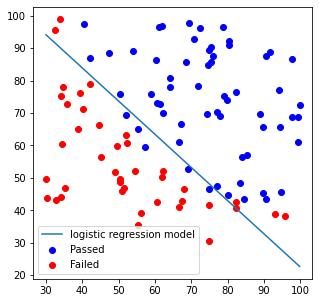

In [189]:
df_passed = df[df["wynik"]==1]
df_failed = df[df["wynik"]==0]

fig, axes = plt.subplots(1,1, figsize=(5,5))
# niebieskie pukty na płaszyźnie ```x="matematyka", y="biologia"``` dla osób które zdały.  

axes.scatter(df_passed['matematyka'], df_passed['biologia'], label="Passed", c='b')

# czerwone pukty na płaszyźnie ```x="matematyka", y="biologia"``` dla osób które nie zdały.

axes.scatter(df_failed['matematyka'], df_failed['biologia'], label="Failed", c='r')

# prosta rodzielająca klasy
x = np.array([df["matematyka"].min(),df["matematyka"].max()])
y = -1/(theta_opt[2]) * (theta_opt[0] + theta_opt[1]*x)

# print(df_passed["matematyka"])
axes.plot(x,y, label="logistic regression model")
axes.legend();

# Zadanie domowe

Zastosowanie regresji liniowej do innego rodzaju danych.

**Proszę:**

* wygenerować syntetyczne wyniki 100 egzaminów z biologi i matematyki według rozkładu płaskiego w zakresie ```[0,100]``` punktów
* proszę wygenerować efekt rekrutacji na studia według wzoru:
$$\text{zdał} = \sqrt{(\text{wynik z matematyki}-50)^{2} + (\text{wynik z biologii}-50)^{2}}>25$$

* narysować rozkład osób które zdały/nie zdały na płaszczyście ```x="matematyka", y="biologia"```
* przeprowadzić trening regresji logistycznej dla tych danych
* narysować krzywą rozdzielającą kategorie
* odpowiedzieć na pytanie "Czy krzywa poprawnie rozdziela kategorie?"

In [190]:
nPoints = 1000

# data generation
mat_res = np.random.uniform(0, 100, 100)
bio_res = np.random.uniform(0, 100, 100)

# formula preparation
bra1 = (mat_res-50)**2
bra2 = (bio_res-50)**2
uni_res = np.sqrt(bra1+bra2)

passed = uni_res>25

# our dataframe
df = pd.DataFrame(
    {'matematyka' : mat_res,
    'biologia' : bio_res,
    'wynik' : passed}
)

df_passed = df[df['wynik']==1]  # passed
df_failed = df[df['wynik']==0]  # failed


Plots

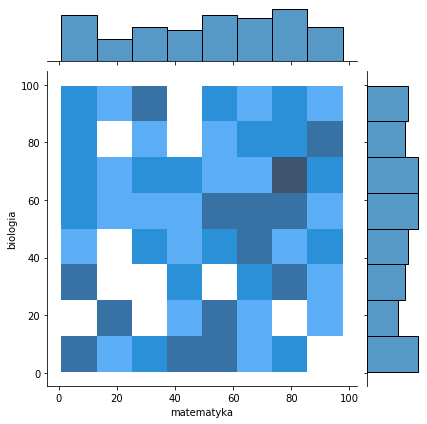

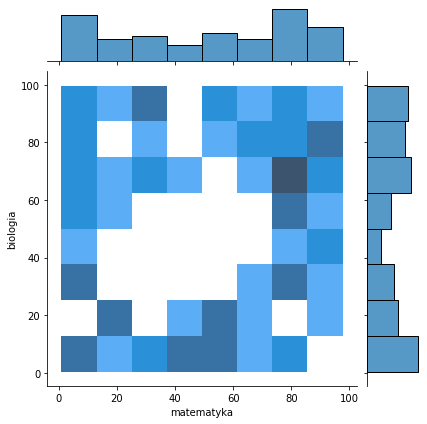

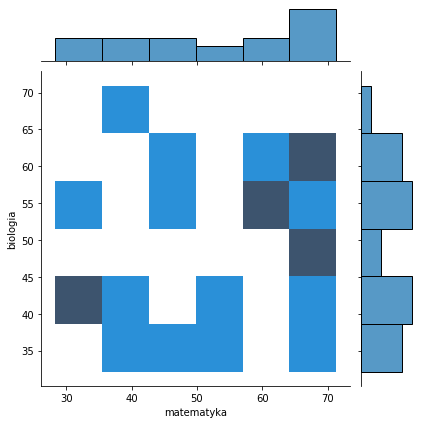

In [191]:
# wszysktie
sns.jointplot(data=df, x="matematyka", y="biologia", kind='hist')  # hue odcien na podstawie ktorej kolumny

# zdane
sns.jointplot(data=df_passed, x="matematyka", y="biologia", kind='hist')

# niezdane
sns.jointplot(data=df_failed, x="matematyka", y="biologia", kind='hist')

Regresja logistyczna

In [192]:
theta = np.array([0, 0, 0])

x = df[['matematyka', 'biologia']]
y = df['wynik']

# wartość funkcji log-wiarygodności

llh = log_likelihood(theta, x, y, logistic_func)
# wartość pochodnej

llh_derivative = log_likelihood_derivative(theta, x, y, logistic_func)

In [193]:
%%time 
# komenda ``time``` włącza licznik czasu wykonywania komórki

model = logistic_func

# poszukiwanie optymalnych wartości parametrów theta
theta_opt = so.fmin_bfgs(f=negative_log_likelihood, fprime=negative_log_likelihood_derivative, x0=theta, args=(x, y, model), disp=True)
# wartość LLH z optymalnymi parametrami

llh = log_likelihood(theta_opt, x, y, model)

print('Optymalne wartości parametrów theta: {}'.format(theta_opt))
print("Wartość funkcji log-wiarygodności dla optymalnych parametrów: {}".format(llh))

Optimization terminated successfully.
         Current function value: 51.342772
         Iterations: 11
         Function evaluations: 19
         Gradient evaluations: 19
Optymalne wartości parametrów theta: [ 1.28154903 -0.00156691  0.00249883]
Wartość funkcji log-wiarygodności dla optymalnych parametrów: -51.34277153367229
CPU times: total: 0 ns
Wall time: 20 ms


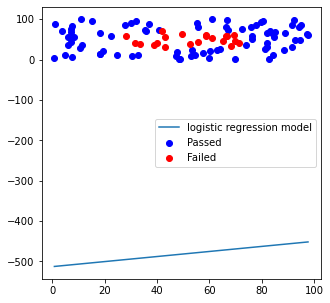

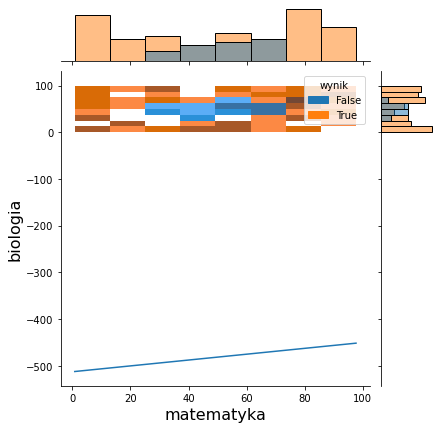

In [194]:
df_passed = df[df["wynik"]==1]
df_failed = df[df["wynik"]==0]

fig, axes = plt.subplots(1,1, figsize=(5,5))
# niebieskie pukty na płaszyźnie ```x="matematyka", y="biologia"``` dla osób które zdały.  

axes.scatter(df_passed['matematyka'], df_passed['biologia'], label="Passed", c='b')

# czerwone pukty na płaszyźnie ```x="matematyka", y="biologia"``` dla osób które nie zdały.

axes.scatter(df_failed['matematyka'], df_failed['biologia'], label="Failed", c='r')

# prosta rodzielająca klasy
x = np.array([df["matematyka"].min(),df["matematyka"].max()])
y = -1/(theta_opt[2]) * (theta_opt[0] + theta_opt[1]*x)

# print(df_passed["matematyka"])
axes.plot(x,y, label="logistic regression model")
axes.legend();

jointPlot = sns.jointplot(x="matematyka", y="biologia", data=df, kind='hist', hue="wynik")
jointPlot.set_axis_labels('matematyka', 'biologia', fontsize=16);

jointPlot.ax_joint.plot(x,y, label="logistic regression model");


## Odpowiedź na pytanie w pracy domowej: Krzywa nie rozdziela poprawnie kategorii